<a href="https://colab.research.google.com/github/Hjhirp/Climate-Change-Prediction/blob/main/Notebook/Climate_Change_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import Data & Modules**

In [ ]:
# connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/OMDENA SV

/content/gdrive/MyDrive/OMDENA SV


In [ ]:
# # Check if you're using GPU runtime type
# # Read this post about Google Colab GPU Usage Limit: https://stackoverflow.com/questions/61126851/how-can-i-use-gpu-again-on-google-colab-after-exceeding-usage-limit
# import torch
# torch.cuda.is_available()

In [ ]:
!pip install catboost

     |████████████████████████████████| 76.1 MB 62 kB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA

from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression

from math import sqrt

import joblib # for saving models

pd.options.display.max_columns = 100
pd.options.display.max_rows = 1000

In [ ]:
# Read in the train data from the gdrive
train_data = pd.read_csv('train.csv')
print(train_data.shape)
train_data

(75757, 64)


,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75752,6,State_11,Commercial,Office_Uncategorized,20410.0,1995.0,8.0,36.6,28,43.451613,56,34,47.672414,64,35,49.354839,71,40,56.266667,89,45,59.193548,88,47,63.566667,91,54,66.951613,87,52,68.612903,91,44,61.383333,79,39,55.403226,68,40,51.283333,71,24,38.532258,51,260,3772,45.03,1.4,1,55.147541,6,0,0,0,25,3,0,0,NaN,NaN,NaN,NaN,132.918411,75752
75753,6,State_11,Residential,5plus_Unit_Building,40489.0,1910.0,98.0,36.6,28,43.451613,56,34,47.672414,64,35,49.354839,71,40,56.266667,89,45,59.193548,88,47,63.566667,91,54,66.951613,87,52,68.612903,91,44,61.383333,79,39,55.403226,68,40,51.283333,71,24,38.532258,51,260,3772,45.03,1.4,1,55.147541,6,0,0,0,25,3,0,0,NaN,NaN,NaN,NaN,39.483672,75753
75754,6,State_11,Commercial,Commercial_Other,28072.0,1917.0,NaN,36.6,26,36.612903,48,30,41.637931,58,29,41.338710,62,34,50.183333,79,40,52.145161,79,41,56.233333,86,48,58.758065,81,48,61.612903,87,41,53.783333,73,37,47.661290,59,34,44.650000,62,15,30.338710,46,55,6218,106.32,36.6,438,47.911202,26,2,0,0,6,0,0,0,NaN,NaN

In [ ]:
# For removing duplicate rows from the train data , 39 records are removed
train_data.set_index(['id'], inplace=True)
train_data.drop_duplicates(inplace=True)
print("Shape of train data :", train_data.shape)

Shape of train data : (75718, 63)


In [ ]:
# Convert 0 values in year_built to np.nan
train_data.loc[train_data.year_built == 0, 'year_built'] = np.nan
train_data['year_built'].isnull().sum() # Output should be 1823

1823

## **Encoding Facility Type**

In [ ]:
train_data["facility_type"]=train_data["facility_type"].replace(['Warehouse_Refrigerated','Warehouse_Uncategorized'],"Warehouse_Low")
train_data["facility_type"]=train_data["facility_type"].replace(['Warehouse_Selfstorage','Warehouse_Distribution_or_Shipping_center'],"Warehouse_Med")
train_data["facility_type"]=train_data["facility_type"].replace(['Warehouse_Nonrefrigerated','Data_Center'],"Warehouse_High")

train_data["facility_type"]=train_data["facility_type"].replace(['Mixed_Use_Predominantly_Commercial','Retail_Vehicle_dealership_showroom'],"Commercial_Low")
train_data["facility_type"]=train_data["facility_type"].replace(['Commercial_Other','Commercial_Unknown','Mixed_Use_Commercial_and_Residential','Retail_Enclosed_mall','Retail_Strip_shopping_mall','Retail_Uncategorized'],"Commercial_High")

train_data["facility_type"]=train_data["facility_type"].replace(['Lodging_Uncategorized'],"Lodging_Low")
train_data["facility_type"]=train_data["facility_type"].replace(['Lodging_Other'],"Lodging_Med")
train_data["facility_type"]=train_data["facility_type"].replace(['Lodging_Dormitory_or_fraternity_sorority','Lodging_Hotel'],"Lodging_High")

train_data["facility_type"]=train_data["facility_type"].replace(['Education_Preschool_or_daycare'],"Educational_Low")
train_data["facility_type"]=train_data["facility_type"].replace(['Education_College_or_university','Education_Other_classroom','Education_Uncategorized'],"Educational_High")

train_data["facility_type"]=train_data["facility_type"].replace(['Food_Service_Other'],"Food_Low")
train_data["facility_type"]=train_data["facility_type"].replace(['Food_Service_Restaurant_or_cafeteria','Food_Service_Uncategorized','Grocery_store_or_food_market'],"Food_Med")
train_data["facility_type"]=train_data["facility_type"].replace(['Food_Sales'],"Food_High")

train_data["facility_type"]=train_data["facility_type"].replace(['Public_Assembly_Library','Public_Assembly_Movie_Theater','Public_Assembly_Stadium' , 'Public_Safety_Fire_or_police_station','Public_Safety_Penitentiary','Public_Safety_Uncategorized','Religious_worship'],"Public_Services_Low")
train_data["facility_type"]=train_data["facility_type"].replace(['Parking_Garage','Public_Assembly_Entertainment_culture','Public_Assembly_Other' , 'Public_Assembly_Social_meeting','Public_Assembly_Uncategorized','Public_Safety_Courthouse'],"Public_Services_High")

train_data["facility_type"]=train_data["facility_type"].replace(['Service_Drycleaning_or_Laundry'],"Services_Low")
train_data["facility_type"]=train_data["facility_type"].replace(['Service_Uncategorized','Service_Vehicle_service_repair_shop'],"Services_High")

train_data["facility_type"]=train_data["facility_type"].replace(['Health_Care_Outpatient_Clinic','Health_Care_Outpatient_Uncategorized','Nursing_Home','Office_Medical_non_diagnostic'],"Healthcare_Low")
train_data["facility_type"]=train_data["facility_type"].replace(['Health_Care_Uncategorized','Health_Care_Inpatient','Laboratory'],"Healthcare_High")

train_data["facility_type"]=train_data["facility_type"].replace(['Office_Mixed_use'],"Office_Low")
train_data["facility_type"]=train_data["facility_type"].replace(['Office_Bank_or_other_financial','Office_Uncategorized'],"Office_High")

train_data["facility_type"]=train_data["facility_type"].replace(['Mixed_Use_Predominantly_Residential'],"Residential_Low")
train_data["facility_type"]=train_data["facility_type"].replace(['2to4_Unit_Building','5plus_Unit_Building'],"Residential_Med")
train_data["facility_type"]=train_data["facility_type"].replace(['Multifamily_Uncategorized'],"Residential_High")

In [ ]:
# train_data['facility_type_group'] = train_data["facility_type"]
# train_data['facility_type_group'].isnull().sum() # Check the results

In [ ]:
train_data['facility_type']

id
0                Food_Med
1           Warehouse_Med
2         Commercial_High
3        Educational_High
4          Warehouse_High
               ...       
75752         Office_High
75753     Residential_Med
75754     Commercial_High
75755     Commercial_High
75756     Residential_Med
Name: facility_type, Length: 75718, dtype: object

## **Imputation & Clustering**

In [ ]:
# Before doing any scaling, imputation, or clustering that's using distance-based algorithms, we first have to split the data
training_cols = [col for col in train_data.columns if col != 'site_eui']
X = train_data[training_cols]
y = train_data['site_eui']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

### **Year_Built Imputation**

- [A simple guide to KNNImputer by Kaushik Roy Chowdhury on Analytics Vidhaya ](https://www.analyticsvidhya.com/blog/2020/07/knnimputer-a-robust-way-to-impute-missing-values-using-scikit-learn/)
- [Using fancyimpute in Python by Raji Rai on Medium](https://krrai77.medium.com/using-fancyimpute-in-python-eadcffece782)

This time let's just consider `Year_Built` as discrete numerical values and use KNNImputer. Will be using `floor_area`, `facility_type_group`, `State_Factor`, and `Year_Factor` as training features for the KNN algorithm based on [this article](https://www.eia.gov/consumption/commercial/reports/2012/buildstock/) and my insights.

In [ ]:
def ordinal_encode_for_knn_imputer(data):
  """
  Writer: Dongyeun K.
  Description: This is for preprocessing job before passing the data to KNNImputer
  """
  from sklearn.preprocessing import OrdinalEncoder

  # Encode facility_type_group
  facility_type_group_ord_encoder = OrdinalEncoder()
  facility_type_group_reshaped = data['facility_type'].values.reshape(-1, 1)
  facility_type_group_encoded = facility_type_group_ord_encoder.fit_transform(facility_type_group_reshaped)

  # Encode State_Factor
  state_factor_ord_encoder = OrdinalEncoder()
  state_factor_reshaped = data['State_Factor'].values.reshape(-1, 1)
  state_factor_encoded = state_factor_ord_encoder.fit_transform(state_factor_reshaped)

  # Add encoded columns
  data['facility_type_group_enc'] = np.squeeze(facility_type_group_encoded)
  data['state_factor_enc'] = np.squeeze(state_factor_encoded)

  # Drop original columns
  data.drop(['State_Factor', 'facility_type'], axis=1, inplace=True)

  return data


def find_optimal_n(data, start_range, end_range, step=2, target='site_eui'):
  """
  Wrtier: Dongyeun Kum
  Description: Interatively calculates RMSE for a given rage of number_of_neighbors parameter;Denoted as 'n'
  """
  from sklearn.model_selection import train_test_split
  from sklearn.preprocessing import RobustScaler
  from sklearn.ensemble import GradientBoostingRegressor
  from sklearn.impute import KNNImputer

  X = data.drop(target, axis=1)
  y = data[target]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

  # Scale data X before feeding the KNNImputer
  transformer = RobustScaler()
  X_train_scaled_arr = transformer.fit_transform(X_train)
  X_test_scaled_arr = transformer.transform(X_test)

  X_train_scaled = pd.DataFrame(X_train_scaled_arr, columns=X_train.columns)
  X_test_scaled = pd.DataFrame(X_test_scaled_arr, columns=X_test.columns)

  errors = []

  for n in range(start_range, end_range, step):
    imputer = KNNImputer(n_neighbors= n)
    X_train_imputed_arr = imputer.fit_transform(X_train_scaled)
    X_test_imputed_arr = imputer.transform(X_test_scaled)

    X_train_imputed = pd.DataFrame(X_train_imputed_arr, columns = X_train_scaled.columns)
    X_test_imputed = pd.DataFrame(X_test_imputed_arr, columns = X_test_scaled.columns)

    model = GradientBoostingRegressor(random_state=42)
    model.fit(X_train_imputed, y_train)
    y_pred = model.predict(X_test_imputed)
    error = (mean_squared_error(y_test, y_pred))**0.5

    errors.append({'num_of_neighbors': n, 'RMSE': error})

  df_errors = pd.DataFrame(errors)

  return df_errors


def visualize_knn_optimization(df_errors):
  """
  Writer: Dongyeun Kum
  Description: Visualizes how RMSE varies as n of KNN changes
  """
  import seaborn as sns

  sns.lineplot(df_errors.num_of_neighbors, df_errors.RMSE)
  plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

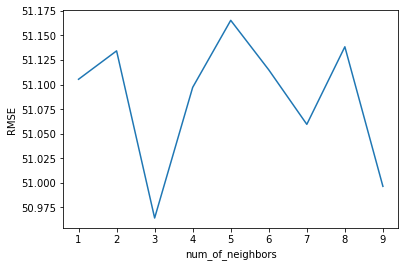

In [ ]:
# Get optimal number of neighbors for KNNImputer
data_temp = train_data[['Year_Factor', 'State_Factor', 'facility_type', 'floor_area', 'year_built', 'site_eui']]
data_temp_ordinal = ordinal_encode_for_knn_imputer(data_temp)
df_errors = find_optimal_n(data_temp_ordinal, 1, 10, step=1)
visualize_knn_optimization(df_errors)

In [ ]:
# KNN Imputation with the optimal n - This process is to be functionized soon
X_train_copy = copy.deepcopy(X_train)
X_test_copy = copy.deepcopy(X_test)

ord_encoder = OrdinalEncoder()
transformer = RobustScaler()
KNN_imputer = KNNImputer(n_neighbors=4) # the optimal n=4

knn_cols = ['Year_Factor', 'state_factor_enc', 'facility_type_group_enc', 'floor_area', 'year_built']

X_train_copy_enc = ordinal_encode_for_knn_imputer(X_train_copy) # ordinal encoding
X_test_copy_enc = ordinal_encode_for_knn_imputer(X_test_copy)

X_train_copy_scaled_arr = transformer.fit_transform(X_train_copy_enc[knn_cols]) # scaling
X_test_copy_scaled_arr = transformer.transform(X_test_copy_enc[knn_cols]) # scaling

X_train_copy_scaled = pd.DataFrame(X_train_copy_scaled_arr, columns=knn_cols, index=X_train_copy_enc.index)
X_test_copy_scaled = pd.DataFrame(X_test_copy_scaled_arr, columns=knn_cols, index=X_test_copy_enc.index)

X_train_copy_knn_imputed_arr = KNN_imputer.fit_transform(X_train_copy_scaled[['Year_Factor', 'state_factor_enc', 'facility_type_group_enc', 'floor_area', 'year_built']])
X_test_copy_knn_imputed_arr = KNN_imputer.transform(X_test_copy_scaled[['Year_Factor', 'state_factor_enc', 'facility_type_group_enc', 'floor_area', 'year_built']])

X_train_copy_knn_imputed = transformer.inverse_transform(X_train_copy_knn_imputed_arr)
X_test_copy_knn_imputed = transformer.inverse_transform(X_test_copy_knn_imputed_arr)

X_train_copy_knn_imputed = pd.DataFrame(X_train_copy_knn_imputed, columns= knn_cols, index = X_train_copy_enc.index)
X_test_copy_knn_imputed = pd.DataFrame(X_test_copy_knn_imputed, columns= knn_cols, index = X_test_copy_enc.index)

X_train_copy_knn_imputed # Check the results

,Year_Factor,state_factor_enc,facility_type_group_enc,floor_area,year_built
id,,,,,
49286,5.0,5.0,19.0,102900.0,1957.0
2662,4.0,0.0,13.0,85554.0,1915.0
63784,6.0,5.0,8.0,76432.0,1937.0
24486,2.0,5.0,19.0,58338.0,1928.0
37347,4.0,5.0,19.0,210000.0,1949.0
...,...,...,...,...,...
37222,4.0,5.0,10.0,52222.0,1900.0
6271,4.0,3.0,13.0,319955.0,2001.0
54919,6.0,5.0,12.0,27528.0,1990.0


In [ ]:
# Replace NaN values in year_built - X_train
X_train['year_built_imputed'] = round(X_train_copy_knn_imputed['year_built'])

print(X_train.year_built_imputed.isnull().sum())
X_train[['year_built', 'year_built_imputed']]

0


,year_built,year_built_imputed
id,,
49286,1957.0,1957.0
2662,NaN,1915.0
63784,1937.0,1937.0
24486,1928.0,1928.0
37347,1949.0,1949.0
...,...,...
37222,1900.0,1900.0
6271,2001.0,2001.0
54919,1990.0,1990.0


In [ ]:
# Replace NaN values in year_built - X_test
X_test['year_built_imputed'] = round(X_test_copy_knn_imputed['year_built'])

print(X_test.year_built_imputed.isnull().sum())
X_test[['year_built', 'year_built_imputed']]

0


,year_built,year_built_imputed
id,,
37620,1929.0,1929.0
564,1921.0,1921.0
25718,1925.0,1925.0
29778,1942.0,1942.0
68501,1983.0,1983.0
...,...,...
71119,1988.0,1988.0
45838,1939.0,1939.0
1534,1923.0,1923.0


In [ ]:
# # Visualize the results
# year_built_count = pd.DataFrame(train_df[train_df['year_built'] != 0]['year_built'].value_counts(dropna=False).sort_index(ascending=True)).reset_index().rename(columns={'index': 'year_built', 'year_built': 'count'})
# year_built_imputed_count = pd.DataFrame(train_df_knn['year_built_imputed'].value_counts().sort_index(ascending=True)).reset_index().rename(columns={'index': 'year_built_imputed', 'year_built_imputed': 'count'})

# sns.displot(year_built_count, x="year_built")
# sns.displot(year_built_imputed_count, x="year_built_imputed")

### **Climate**

#### Additional work: Try add Yearly Temp Range

In [ ]:
temp_cols = [col for col in X_train.columns if ('temp' in col) and ('avg_' not in col)]

for col in enumerate(temp_cols):
  X_train['temp_range'] = X_train[temp_cols].apply(lambda row: max(row) - min(row), axis=1) # row-wise max - min subtraction

X_train

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,year_built_imputed,temp_range
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
49286,5,State_6,Residential,Residential_High,102900.0,1957.0,NaN,42.7,8,29.854839,56,2,23.946429,43,12,38.096774,62,32,54.250000,80,48,68.516129,88,50,71.183333,90,64,78.790323,96,63,78.967742,95,56,74.450000,97,35,58.048387,78,32,52.783333,74,34,50.774194,72,1581,4460,40.97,49.1,463,56.835616,63,34,9,0,106,12,0,0,310.0,310.0,13.0,110.0,1957.0,95
2662,4,State_1,Commercial,Office_High,85554.0,NaN,79.0,120.4,41,55.096774,73,42,54.875000,71,47,59.032258,76,47,60.100000,90,51,63.483871,92,52,64.250000,87,53,66.903226,90,57,67.016129,80,56,68.383333,83,55,68.661290,95,46,59.650000,76,41,56.790323,68,497,1477,20.69,0.0,0,62.067123,0,0,0,0,27,6,0,0,NaN,NaN,NaN,NaN,1915.0,54
63784,6,State_6,Commercial,Healthcare_Low,76432.0,1937.0,NaN,25.0,11,34.451613,59,-1,37.706897,61,26,48.870968,79,26,53.333333,82,43,62.790323,92,52,72.250000,88,63,78.677419,96,61,79.177419,96,54,71.800000,91,38,58.758065,85,34,49.766667,72,17,38.338710,60,1489,4252,42.17,36.0,101,57.215847,40,11,2,1,96,17,0,0,1.0,1.0,1.0,NaN,1937.0,97
24486,2,State_6,Residential,Residential_High,58338.0,1928.0,NaN,3.4,13,37.322581,62,20,40.879310,62,25,50.935484,78,38,54.766667,88,49,65.096774,89,51,70.983333,94,61,78.758065,100,61,76.693548,91,53,68.800000,91,38,58.048387,78,31,43.866667,66,28,41.467742,62,1277,3978,38.51,9.6,10,57.366120,22,5,0,0,72,17,0,0,1.0,1.0,1.0,56.0,1928.0,87
37347,4,State_6,Residential,Residential_High,210000.0,1949.0,1.0,3.4,4,28.596774,58,9,31.625000,56,13,37.661290,66,31,52.333333,77,49,64.000000,86,55,72.450000,89,63,76.145161,91,61,74.516129,90,52,69.733333,92,42,59.629032,77,22,45.300000,69,24,40.516129,65,1128,4875,53.79,50.0,377,54.501370,66,24,7,0,75,4,0,0,1.0,1.0,1.0,NaN,1949.0,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37222,4,State_6,Commercial,Lodging_High,52222.0,1900.0,22.0,42.7,4,28.596774,58,9,31.625000,56,13,37.661290,66,31,52.333333,77,49,64.000000,86,55,72.450000,89,63,76.145161,91,61,74.516129,90,52,69.733333,92,42,59.629032,77,22,45.300000,69,24,40.516129,65,1128,4875,53.79,50.0,377,54.501370,66,24,7,0,75,4,0,0,1.0,1.0,1.0,NaN,1900.0,88
6271,4,State_2,Commercial,Office_High,319955.0,2001.0,89.0,47.5,3,28.290323,59,13,34.107143,68,7,37.951613,70,31,54.450000,84,44,65.034483,90,54,74.483333,95,55,76.033333,97,55,73.550000,89,46,69.172414,93,38,59.183333,81,19,43.357143,72,23,40.350000,72,1170,4760,53.09,31.6,39,54.651685,88,26,12,0,93,17,0,0,1.0,1.0,1.0,110.0,2001.0,94
54919,6,State_6,Commercial,Lodging_Med,27528.0,1990.0,NaN,3.4,11,34.451613,59,-1,37.706897,61,26,48.870968,79,26,53.333333,82,43,62.790323,92,52,72.250000,88,63,78.677419,96,61,79.177419,96,54,71.800000,91,38,58.758065,85,34,49.766667,72,17,38.338710,60,1489,4252,42.17,36.0,101,57.215

In [ ]:
# Add temp_range to the test set (validation set)
for col in enumerate(temp_cols):
  X_test['temp_range'] = X_test[temp_cols].apply(lambda row: max(row) - min(row), axis=1) # row-wise max - min subtraction

X_test

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,year_built_imputed,temp_range
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
37620,4,State_6,Residential,Residential_High,111225.0,1929.0,NaN,42.7,4,28.596774,58,9,31.625000,56,13,37.661290,66,31,52.333333,77,49,64.000000,86,55,72.450000,89,63,76.145161,91,61,74.516129,90,52,69.733333,92,42,59.629032,77,22,45.300000,69,24,40.516129,65,1128,4875,53.79,50.0,377,54.501370,66,24,7,0,75,4,0,0,1.0,1.0,1.0,NaN,1929.0,88
564,2,State_1,Commercial,Office_High,55785.0,1921.0,84.0,2.4,27,48.951613,69,33,51.655172,78,34,52.822581,74,37,58.850000,90,45,64.612903,92,49,67.900000,103,53,70.467742,99,52,71.806452,100,49,68.466667,97,43,63.983871,100,35,55.283333,79,28,47.919355,65,791,2439,19.27,0.0,0,60.247268,3,0,0,0,113,35,1,0,1.0,1.0,1.0,88.0,1921.0,76
25718,3,State_6,Residential,Residential_High,84000.0,1925.0,NaN,11.9,11,35.080645,61,17,33.910714,55,27,40.145161,59,33,52.983333,82,42,62.790323,90,53,72.650000,92,64,79.838710,98,59,74.596774,90,47,67.866667,96,40,60.193548,86,23,45.250000,70,19,38.548387,71,1272,4670,46.32,29.6,64,55.449315,50,11,0,0,75,11,0,0,NaN,NaN,NaN,NaN,1925.0,87
29778,3,State_6,Residential,Residential_High,135000.0,1942.0,NaN,15.2,11,35.080645,61,17,33.910714,55,27,40.145161,59,33,52.983333,82,42,62.790323,90,53,72.650000,92,64,79.838710,98,59,74.596774,90,47,67.866667,96,40,60.193548,86,23,45.250000,70,19,38.548387,71,1272,4670,46.32,29.6,64,55.449315,50,11,0,0,75,11,0,0,NaN,NaN,NaN,NaN,1942.0,87
68501,6,State_8,Commercial,Office_High,1111787.0,1983.0,91.0,3.0,8,29.827586,62,4,33.896552,62,24,45.967742,79,18,49.931034,81,37,59.161290,89,45,70.465517,90,57,77.083333,96,54,75.725806,95,40,68.200000,96,24,55.258065,85,20,44.316667,71,12,35.129032,58,1114,5074,35.78,13.9,18,53.839335,97,29,6,0,101,21,0,0,1.0,1.0,1.0,116.0,1983.0,92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71119,5,State_11,Residential,Commercial_High,19237.0,1988.0,NaN,18.3,28,45.419355,63,32,48.321429,62,29,50.725806,71,37,51.850000,78,41,59.080645,81,48,67.083333,90,55,70.919355,96,51,68.403226,89,44,60.433333,80,46,57.500000,74,27,44.466667,59,29,43.435484,58,430,3742,39.35,0.0,0,55.693151,8,0,0,0,40,2,0,0,NaN,NaN,NaN,NaN,1988.0,69
45838,5,State_6,Residential,Residential_High,84472.0,1939.0,90.0,15.2,8,29.854839,56,2,23.946429,43,12,38.096774,62,32,54.250000,80,48,68.516129,88,50,71.183333,90,64,78.790323,96,63,78.967742,95,56,74.450000,97,35,58.048387,78,32,52.783333,74,34,50.774194,72,1581,4460,40.97,49.1,463,56.835616,63,34,9,0,106,12,0,0,NaN,NaN,NaN,NaN,1939.0,95
1534,3,State_1,Residential,Commercial_Low,19420.0,1923.0,NaN,45.7,22,44.790323,65,25,47.892857,71,32,53.112903,79,34,58.866667,87,35,62.096774,91,44,66.283333,99,48,65.693548,91,45,67.080645,92,42,65.950000,96,35,56.967742,85,31,52.516667,76,16,43.338710,68,303,3108,4.16,0.0,0,57

In [ ]:
# PCA - ref: https://www.researchgate.net/post/Is-it-necessary-to-normalize-data-before-performing-principle-component-analysis#:~:text=Yes%2C%20it%20is%20necessary%20to,projection%20of%20your%20data%20set.&text=If%20you%20normalize%20your%20data,your%20PCA%20calculates%20relevant%20axis.

# Scale the X_train data
pca_cols = ['avg_temp','cooling_degree_days',
       'heating_degree_days', 'precipitation_inches', 'snowfall_inches',
       'snowdepth_inches', 'days_below_30F', 'days_below_20F',
       'days_below_10F', 'days_below_0F', 'days_above_80F', 'days_above_90F',
       'days_above_100F', 'days_above_110F', 'temp_range'] #'ELEVATION

X_train_pca = X_train[pca_cols]
X_train_pca.corr() # checking correlation among the weather features

,avg_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,temp_range
avg_temp,1.000000,0.203833,-0.887406,-0.572624,-0.361497,-0.289710,-0.677886,-0.599391,-0.634359,-0.570015,0.177618,0.430304,0.410248,0.111524,-0.352907
cooling_degree_days,0.203833,1.000000,0.268929,0.196944,0.569156,0.334492,0.370309,0.317374,0.058255,-0.117871,0.844076,0.488491,0.136465,0.098028,0.750554
heating_degree_days,-0.887406,0.268929,1.000000,0.659468,0.630397,0.448268,0.829529,0.728576,0.639966,0.503333,0.213390,-0.204421,-0.340074,-0.063900,0.699660
precipitation_inches,-0.572624,0.196944,0.659468,1.000000,0.560788,0.409943,0.443261,0.265181,0.150889,-0.007504,-0.043442,-0.349988,-0.341265,-0.061731,0.364705
snowfall_inches,-0.361497,0.569156,0.630397,0.560788,1.000000,0.843330,0.664640,0.668897,0.434035,0.157433,0.448713,-0.174528,-0.177248,-0.028567,0.679210
snowdepth_inches,-0.289710,0.334492,0.448268,0.409943,0.843330,1.000000,0.537175,0.686445,0.503207,0.146325,0.307603,-0.252865,-0.092549,-0.016462,0.439036
days_below_30F,-0.677886,0.370309,0.829529,0.443261,0.664640,0.537175,1.000000,0.896167,0.759696,0.453323,0.484291,0.029947,-0.168651,-0.023771,0.711643
days_below_20F,-0.599391,0.317374,0.728576,0.265181,0.668897,0.686445,0.896167,1.000000,0.904431,0.582546,0.451480,-0.012149,-0.141135,-0.020745,0.650015
days_below_10F,-0.634359,0.058255,0.639966,0.150889,0.434035,0.503207,0.759696,0.904431,1.000000,0.793197,0.265721,-0.036429,-0.084401,-0.012107,0.520721
days_below_0F,-0.570015,-0.117871,0.503333,-0.007504,0.157433,0.146325,0.453323,0.582546,0.793197,1.000000,0.033426,0.010413,-0.037705,-0.005325,0.397225


In [ ]:
# Scale datasets before pass into PCA
transformer_pca = StandardScaler()
X_train_pca_scaled_arr = transformer_pca.fit_transform(X_train_pca)

X_test_pca = X_test[pca_cols]
X_test_pca_scaled_arr = transformer_pca.transform(X_test_pca)

# PCA
pca = PCA(n_components=1) # create 1 new feature 'climate'
X_train_pca_arr = pca.fit_transform(X_train_pca_scaled_arr)
X_test_pca_arr = pca.transform(X_test_pca_scaled_arr)

In [ ]:
print(pca.explained_variance_ratio_ * 100)

[43.18896412]


In [ ]:
X_train_pca_df = pd.DataFrame(X_train_pca_arr, columns=['climate_pca'], index=X_train_pca.index)
X_test_pca_df = pd.DataFrame(X_test_pca_arr, columns=['climate_pca'], index=X_test_pca.index)

X_train['climate_pca'] = X_train_pca_df['climate_pca']
X_test['climate_pca'] = X_test_pca_df['climate_pca']

X_train

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,year_built_imputed,temp_range,climate_pca
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
49286,5,State_6,Residential,Residential_High,102900.0,1957.0,NaN,42.7,8,29.854839,56,2,23.946429,43,12,38.096774,62,32,54.250000,80,48,68.516129,88,50,71.183333,90,64,78.790323,96,63,78.967742,95,56,74.450000,97,35,58.048387,78,32,52.783333,74,34,50.774194,72,1581,4460,40.97,49.1,463,56.835616,63,34,9,0,106,12,0,0,310.0,310.0,13.0,110.0,1957.0,95,-2.023299
2662,4,State_1,Commercial,Office_High,85554.0,NaN,79.0,120.4,41,55.096774,73,42,54.875000,71,47,59.032258,76,47,60.100000,90,51,63.483871,92,52,64.250000,87,53,66.903226,90,57,67.016129,80,56,68.383333,83,55,68.661290,95,46,59.650000,76,41,56.790323,68,497,1477,20.69,0.0,0,62.067123,0,0,0,0,27,6,0,0,NaN,NaN,NaN,NaN,1915.0,54,6.226570
63784,6,State_6,Commercial,Healthcare_Low,76432.0,1937.0,NaN,25.0,11,34.451613,59,-1,37.706897,61,26,48.870968,79,26,53.333333,82,43,62.790323,92,52,72.250000,88,63,78.677419,96,61,79.177419,96,54,71.800000,91,38,58.758065,85,34,49.766667,72,17,38.338710,60,1489,4252,42.17,36.0,101,57.215847,40,11,2,1,96,17,0,0,1.0,1.0,1.0,NaN,1937.0,97,0.058133
24486,2,State_6,Residential,Residential_High,58338.0,1928.0,NaN,3.4,13,37.322581,62,20,40.879310,62,25,50.935484,78,38,54.766667,88,49,65.096774,89,51,70.983333,94,61,78.758065,100,61,76.693548,91,53,68.800000,91,38,58.048387,78,31,43.866667,66,28,41.467742,62,1277,3978,38.51,9.6,10,57.366120,22,5,0,0,72,17,0,0,1.0,1.0,1.0,56.0,1928.0,87,1.992779
37347,4,State_6,Residential,Residential_High,210000.0,1949.0,1.0,3.4,4,28.596774,58,9,31.625000,56,13,37.661290,66,31,52.333333,77,49,64.000000,86,55,72.450000,89,63,76.145161,91,61,74.516129,90,52,69.733333,92,42,59.629032,77,22,45.300000,69,24,40.516129,65,1128,4875,53.79,50.0,377,54.501370,66,24,7,0,75,4,0,0,1.0,1.0,1.0,NaN,1949.0,88,-1.712063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37222,4,State_6,Commercial,Lodging_High,52222.0,1900.0,22.0,42.7,4,28.596774,58,9,31.625000,56,13,37.661290,66,31,52.333333,77,49,64.000000,86,55,72.450000,89,63,76.145161,91,61,74.516129,90,52,69.733333,92,42,59.629032,77,22,45.300000,69,24,40.516129,65,1128,4875,53.79,50.0,377,54.501370,66,24,7,0,75,4,0,0,1.0,1.0,1.0,NaN,1900.0,88,-1.712063
6271,4,State_2,Commercial,Office_High,319955.0,2001.0,89.0,47.5,3,28.290323,59,13,34.107143,68,7,37.951613,70,31,54.450000,84,44,65.034483,90,54,74.483333,95,55,76.033333,97,55,73.550000,89,46,69.172414,93,38,59.183333,81,19,43.357143,72,23,40.350000,72,1170,4760,53.09,31.6,39,54.651685,88,26,12,0,93,17,0,0,1.0,1.0,1.0,110.0,2001.0,94,-1.631699
54919,6,State_6,Commercial,Lodging_Med,27528.0,1990.0,NaN,3.4,11,34.451613,59,-1,37.706897,61,26,48.870968,79,26,53.333333,82,43,62.790323,92,52,72.250000,88,63,78.677419,96,61,79.177419,96,54,71.80000

### **Location Id**
*WIP

In [ ]:
# KMeans clustering for getting location_id


In [ ]:
print(len(X_train.columns))
print(len(X_test.columns))

65
65


## **Modelling**

### LightGBM

In [ ]:
training_cols = ['facility_type',
 'energy_star_rating',
 'year_built',
 'floor_area',
 'State_Factor']
 # energy_start_rating passed in with null values

X_train_final = pd.get_dummies(X_train[training_cols])
X_test_final = pd.get_dummies(X_test[training_cols])

X_train_final.drop(['facility_type_Lodging_Low'],axis=1,inplace=True)

for i in X_train_final.columns:
  if i not in X_test_final.columns:
    print(i)

In [ ]:
lgbm = lgb.LGBMRegressor(random_state= 42, n_estimators=7000)
lgbm.fit(X_train_final, y_train)
lgbm_pred = lgbm.predict(X_test_final)

print("RMSE:", np.sqrt(mean_squared_error(y_test, lgbm_pred)))

RMSE: 36.10338306813343


In [ ]:
def plot_feature_imp(model):
  feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, X_train_final.columns)), columns=['Importance','Feature'])
  plt.figure(figsize=(20, 10))
  sns.barplot(x="Importance", y="Feature", data=feature_imp.sort_values(by="Importance", ascending=False))
  plt.title(str(model) + 'Features')
  plt.tight_layout()
  plt.show()
  #plt.savefig('lgbm_importances-01.png')

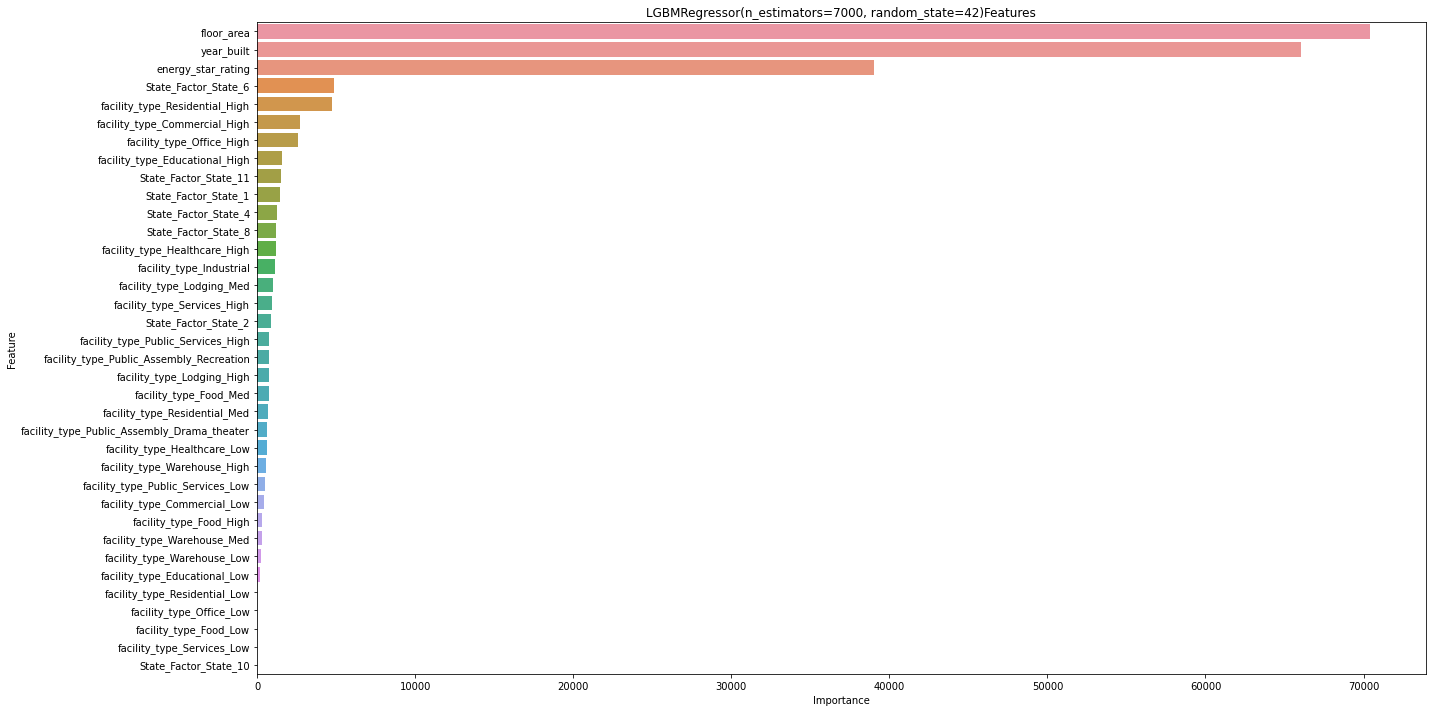

In [ ]:
plot_feature_imp(lgbm)

In [ ]:
# Save model - https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
filename = 'lgbm_220224.sav'
joblib.dump(lgbm, filename)

# # Load the model
# loaded_model = joblib.load(filename)
# result = loaded_model.score(X_test, Y_test)
# print(result)

['lgbm_220223.sav']

### CatBoost

In [ ]:
cb = CatBoostRegressor(random_state=42, iterations=3000, learning_rate=0.02, early_stopping_rounds=300, depth=10)
cb.fit(X_train_final, y_train)
cb_pred = cb.predict(X_test_final)

print("RMSE:", np.sqrt(mean_squared_error(y_test, cb_pred)))

0:	learn: 57.7075577	total: 22.4ms	remaining: 1m 7s
1:	learn: 57.3666365	total: 44.9ms	remaining: 1m 7s
2:	learn: 57.0412589	total: 61.5ms	remaining: 1m 1s
3:	learn: 56.7192252	total: 77.7ms	remaining: 58.2s
4:	learn: 56.4006252	total: 93.7ms	remaining: 56.1s
5:	learn: 56.0922258	total: 110ms	remaining: 55s
6:	learn: 55.7871356	total: 126ms	remaining: 54s
7:	learn: 55.5412786	total: 146ms	remaining: 54.8s
8:	learn: 55.2646314	total: 163ms	remaining: 54s
9:	learn: 54.9930300	total: 179ms	remaining: 53.5s
10:	learn: 54.7403063	total: 196ms	remaining: 53.3s
11:	learn: 54.4832370	total: 213ms	remaining: 53s
12:	learn: 54.2386644	total: 230ms	remaining: 52.8s
13:	learn: 54.0051967	total: 246ms	remaining: 52.5s
14:	learn: 53.7662065	total: 264ms	remaining: 52.5s
15:	learn: 53.5562995	total: 281ms	remaining: 52.5s
16:	learn: 53.3334283	total: 316ms	remaining: 55.5s
17:	learn: 53.1182521	total: 333ms	remaining: 55.2s
18:	learn: 52.9316480	total: 349ms	remaining: 54.8s
19:	learn: 52.7277239	tot

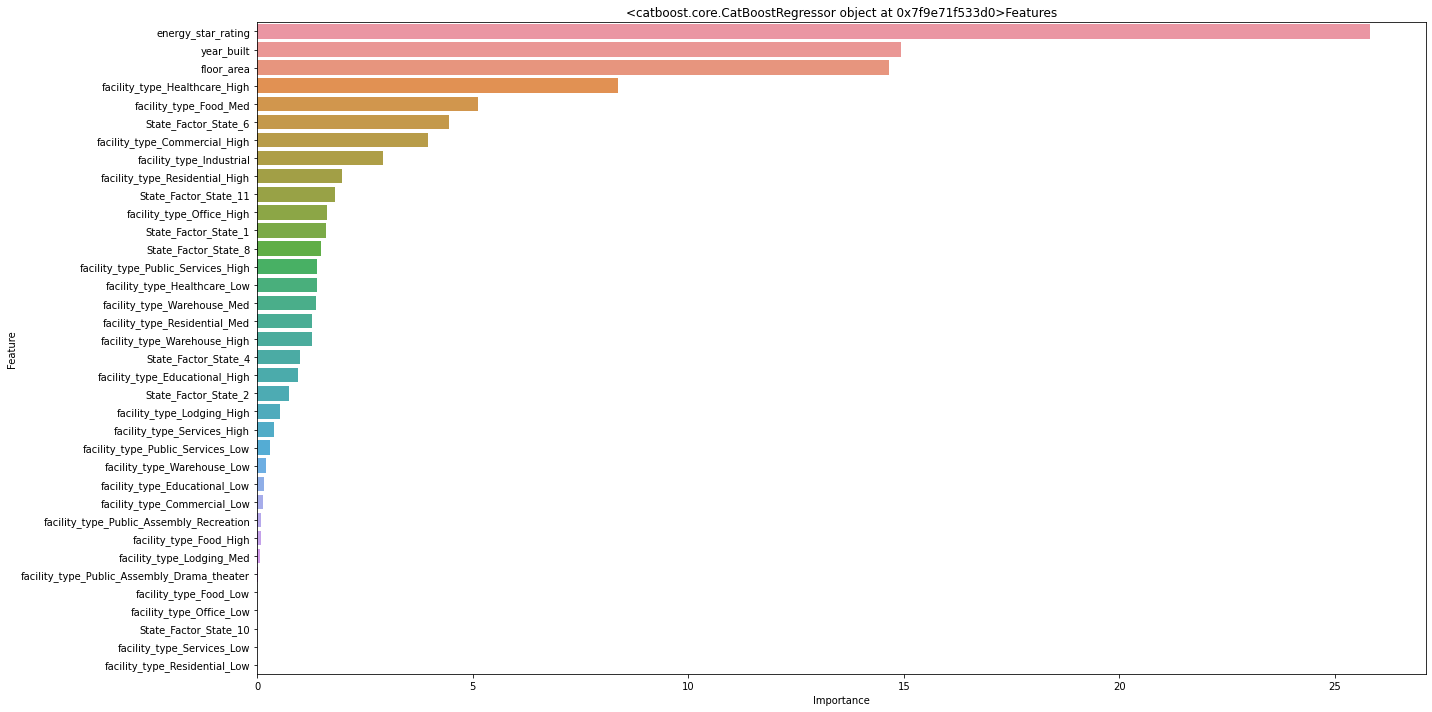

In [ ]:
plot_feature_imp(cb)

In [ ]:
filename2 = 'cb_220224.sav'
joblib.dump(cb, filename2)

['cb_220224.sav']

### XGBoostRegressor

In [ ]:
xgb = XGBRegressor(colsample_bytree=0.8,
                    learning_rate=0.07,
                    max_depth=5,
                    n_estimators=1000,
                    subsample=0.7,
                    seed=42)
xgb.fit(X_train_final, y_train)
xgb_pred = xgb.predict(X_test_final)

print("RMSE:", np.sqrt(mean_squared_error(y_test, xgb_pred)))

[04:52:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 39.565854442220406


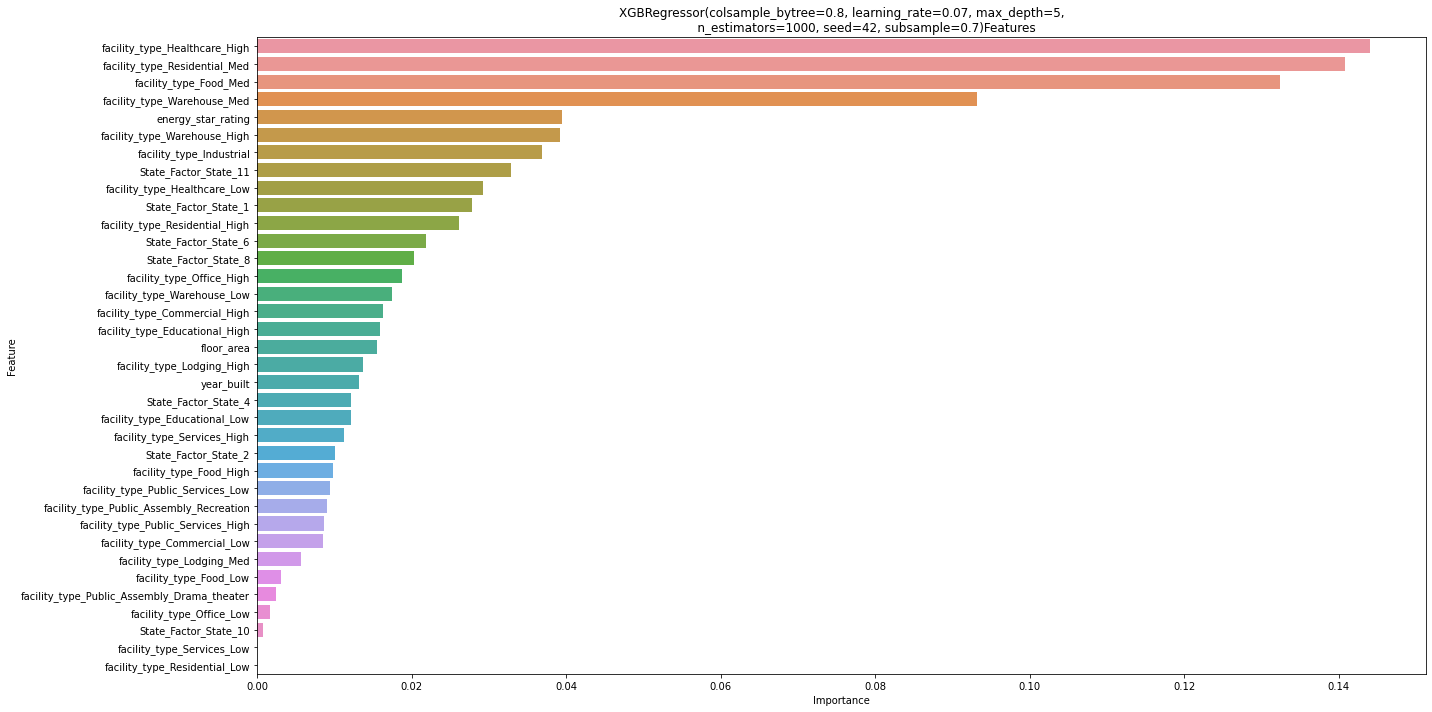

In [ ]:
plot_feature_imp(xgb)

In [ ]:
filename3 = 'xgb_220224.sav'
joblib.dump(xgb, filename3)

['xgb_220224.sav']

## **Submission**

### Preprocessing

In [ ]:
test_data = pd.read_csv('test.csv')
print(test_data.shape)
test_data

(9705, 63)


,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,id
0,7,State_1,Commercial,Grocery_store_or_food_market,28484.0,1994.0,37.0,2.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75757
1,7,State_1,Commercial,Grocery_store_or_food_market,21906.0,1961.0,55.0,45.7,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75758
2,7,State_1,Commercial,Grocery_store_or_food_market,16138.0,1950.0,1.0,59.1,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75759
3,7,State_1,Commercial,Grocery_store_or_food_market,97422.0,1971.0,34.0,35.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75760
4,7,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,35.0,1.8,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,340.0,330.0,22.8,126.0,75761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9700,7,State_11,Residential,5plus_Unit_Building,305925.0,2013.0,99.0,812.0,21,38.661290,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,NaN,NaN,NaN,NaN,85457
9701,7,State_11,Residential,5plus_Unit_Building,34909.0,1910.0,94.0,26.5,21,38.661290,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,NaN,NaN,NaN,NaN,85458
9702,7,State_11,Residential,5plus_Unit_Building,42393.0,2014.0,94.0,812.0,21,38.661290,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,NaN,NaN,NaN,NaN,85459
9703,7,State_11,Residential,5pl

In [ ]:
test_data["facility_type"]=test_data["facility_type"].replace(['Warehouse_Refrigerated','Warehouse_Uncategorized'],"Warehouse_Low")
test_data["facility_type"]=test_data["facility_type"].replace(['Warehouse_Selfstorage','Warehouse_Distribution_or_Shipping_center'],"Warehouse_Med")
test_data["facility_type"]=test_data["facility_type"].replace(['Warehouse_Nonrefrigerated','Data_Center'],"Warehouse_High")

test_data["facility_type"]=test_data["facility_type"].replace(['Mixed_Use_Predominantly_Commercial','Retail_Vehicle_dealership_showroom'],"Commercial_Low")
test_data["facility_type"]=test_data["facility_type"].replace(['Commercial_Other','Commercial_Unknown','Mixed_Use_Commercial_and_Residential','Retail_Enclosed_mall','Retail_Strip_shopping_mall','Retail_Uncategorized'],"Commercial_High")

test_data["facility_type"]=test_data["facility_type"].replace(['Lodging_Uncategorized'],"Lodging_Low")
test_data["facility_type"]=test_data["facility_type"].replace(['Lodging_Other'],"Lodging_Med")
test_data["facility_type"]=test_data["facility_type"].replace(['Lodging_Dormitory_or_fraternity_sorority','Lodging_Hotel'],"Lodging_High")

test_data["facility_type"]=test_data["facility_type"].replace(['Education_Preschool_or_daycare'],"Educational_Low")
test_data["facility_type"]=test_data["facility_type"].replace(['Education_College_or_university','Education_Other_classroom','Education_Uncategorized'],"Educational_High")

test_data["facility_type"]=test_data["facility_type"].replace(['Food_Service_Other'],"Food_Low")
test_data["facility_type"]=test_data["facility_type"].replace(['Food_Service_Restaurant_or_cafeteria','Food_Service_Uncategorized','Grocery_store_or_food_market'],"Food_Med")
test_data["facility_type"]=test_data["facility_type"].replace(['Food_Sales'],"Food_High")

test_data["facility_type"]=test_data["facility_type"].replace(['Public_Assembly_Library','Public_Assembly_Movie_Theater','Public_Assembly_Stadium' , 'Public_Safety_Fire_or_police_station','Public_Safety_Penitentiary','Public_Safety_Uncategorized','Religious_worship'],"Public_Services_Low")
test_data["facility_type"]=test_data["facility_type"].replace(['Parking_Garage','Public_Assembly_Entertainment_culture','Public_Assembly_Other' , 'Public_Assembly_Social_meeting','Public_Assembly_Uncategorized','Public_Safety_Courthouse'],"Public_Services_High")

test_data["facility_type"]=test_data["facility_type"].replace(['Service_Drycleaning_or_Laundry'],"Services_Low")
test_data["facility_type"]=test_data["facility_type"].replace(['Service_Uncategorized','Service_Vehicle_service_repair_shop'],"Services_High")

test_data["facility_type"]=test_data["facility_type"].replace(['Health_Care_Outpatient_Clinic','Health_Care_Outpatient_Uncategorized','Nursing_Home','Office_Medical_non_diagnostic'],"Healthcare_Low")
test_data["facility_type"]=test_data["facility_type"].replace(['Health_Care_Uncategorized','Health_Care_Inpatient','Laboratory'],"Healthcare_High")

test_data["facility_type"]=test_data["facility_type"].replace(['Office_Mixed_use'],"Office_Low")
test_data["facility_type"]=test_data["facility_type"].replace(['Office_Bank_or_other_financial','Office_Uncategorized'],"Office_High")

test_data["facility_type"]=test_data["facility_type"].replace(['Mixed_Use_Predominantly_Residential'],"Residential_Low")
test_data["facility_type"]=test_data["facility_type"].replace(['2to4_Unit_Building','5plus_Unit_Building'],"Residential_Med")
test_data["facility_type"]=test_data["facility_type"].replace(['Multifamily_Uncategorized'],"Residential_High")

In [ ]:
# test_data['facility_type'] = test_data.facility_type.apply(group_facility_type)
test_data['facility_type'].isnull().sum() # Check the results

0

In [ ]:
test_data_copy = copy.deepcopy(test_data)
test_data_copy_enc = ordinal_encode_for_knn_imputer(test_data_copy) # ordinal encoding

test_data_copy_scaled_arr = transformer.transform(test_data_copy_enc[knn_cols]) # scaling

test_data_copy_scaled = pd.DataFrame(test_data_copy_scaled_arr, columns=knn_cols, index=test_data_copy_enc.index)

test_data_copy_knn_imputed_arr = KNN_imputer.transform(test_data_copy_scaled[['Year_Factor', 'state_factor_enc', 'facility_type_group_enc', 'floor_area', 'year_built']])

test_data_copy_knn_imputed = transformer.inverse_transform(test_data_copy_knn_imputed_arr)

test_data_copy_knn_imputed_df = pd.DataFrame(test_data_copy_knn_imputed, columns= knn_cols, index = test_data_copy_enc.index)

test_data_copy_knn_imputed_df

,Year_Factor,state_factor_enc,facility_type_group_enc,floor_area,year_built
0,7.0,0.0,6.0,28484.0,1994.0
1,7.0,0.0,6.0,21906.0,1961.0
2,7.0,0.0,6.0,16138.0,1950.0
3,7.0,0.0,6.0,97422.0,1971.0
4,7.0,0.0,6.0,61242.0,1942.0
...,...,...,...,...,...
9700,7.0,2.0,21.0,305925.0,2013.0
9701,7.0,2.0,21.0,34909.0,1910.0
9702,7.0,2.0,21.0,42393.0,2014.0
9703,7.0,2.0,21.0,25368.0,1992.0


In [ ]:
test_data['year_built_imputed'] = round(test_data_copy_knn_imputed_df['year_built'])
test_data

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,id,year_built_imputed
0,7,State_1,Commercial,Food_Med,28484.0,1994.0,37.0,2.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75757,1994.0
1,7,State_1,Commercial,Food_Med,21906.0,1961.0,55.0,45.7,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75758,1961.0
2,7,State_1,Commercial,Food_Med,16138.0,1950.0,1.0,59.1,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75759,1950.0
3,7,State_1,Commercial,Food_Med,97422.0,1971.0,34.0,35.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75760,1971.0
4,7,State_1,Commercial,Food_Med,61242.0,1942.0,35.0,1.8,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,340.0,330.0,22.8,126.0,75761,1942.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9700,7,State_11,Residential,Residential_Med,305925.0,2013.0,99.0,812.0,21,38.661290,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,NaN,NaN,NaN,NaN,85457,2013.0
9701,7,State_11,Residential,Residential_Med,34909.0,1910.0,94.0,26.5,21,38.661290,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,NaN,NaN,NaN,NaN,85458,1910.0
9702,7,State_11,Residential,Residential_Med,42393.0,2014.0,94.0,812.0,21,38.661290,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,NaN,NaN,NaN,NaN,85459,2014.0
9703,7,State_11,Residential,Residential_Med,25368.0,1992.0,79.0,

In [ ]:
for col in enumerate(temp_cols):
  test_data['temp_range'] = test_data[temp_cols].apply(lambda row: max(row) - min(row), axis=1) # row-wise max - min subtraction

test_data

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,id,year_built_imputed,temp_range
0,7,State_1,Commercial,Food_Med,28484.0,1994.0,37.0,2.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75757,1994.0,66
1,7,State_1,Commercial,Food_Med,21906.0,1961.0,55.0,45.7,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75758,1961.0,66
2,7,State_1,Commercial,Food_Med,16138.0,1950.0,1.0,59.1,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75759,1950.0,66
3,7,State_1,Commercial,Food_Med,97422.0,1971.0,34.0,35.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75760,1971.0,66
4,7,State_1,Commercial,Food_Med,61242.0,1942.0,35.0,1.8,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,340.0,330.0,22.8,126.0,75761,1942.0,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9700,7,State_11,Residential,Residential_Med,305925.0,2013.0,99.0,812.0,21,38.661290,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,NaN,NaN,NaN,NaN,85457,2013.0,72
9701,7,State_11,Residential,Residential_Med,34909.0,1910.0,94.0,26.5,21,38.661290,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,NaN,NaN,NaN,NaN,85458,1910.0,72
9702,7,State_11,Residential,Residential_Med,42393.0,2014.0,94.0,812.0,21,38.661290,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,NaN,NaN,NaN,NaN,85459,2014.0,72
9703,7,State_11,Residenti

In [ ]:
test_data_pca = test_data[pca_cols]
test_data_pca_scaled_arr = transformer_pca.transform(test_data_pca)

# PCA
test_data_pca_arr = pca.transform(test_data_pca_scaled_arr)
test_data_pca_df = pd.DataFrame(test_data_pca_arr, columns=['climate_pca'], index=test_data_pca.index)

test_data['climate_pca'] = test_data_pca_df['climate_pca']
print(test_data['climate_pca'].isnull().sum())
test_data

0


,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,id,year_built_imputed,temp_range,climate_pca
0,7,State_1,Commercial,Food_Med,28484.0,1994.0,37.0,2.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75757,1994.0,66,5.375879
1,7,State_1,Commercial,Food_Med,21906.0,1961.0,55.0,45.7,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75758,1961.0,66,5.375879
2,7,State_1,Commercial,Food_Med,16138.0,1950.0,1.0,59.1,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75759,1950.0,66,5.375879
3,7,State_1,Commercial,Food_Med,97422.0,1971.0,34.0,35.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75760,1971.0,66,5.375879
4,7,State_1,Commercial,Food_Med,61242.0,1942.0,35.0,1.8,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,340.0,330.0,22.8,126.0,75761,1942.0,66,5.375879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9700,7,State_11,Residential,Residential_Med,305925.0,2013.0,99.0,812.0,21,38.661290,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,NaN,NaN,NaN,NaN,85457,2013.0,72,2.529478
9701,7,State_11,Residential,Residential_Med,34909.0,1910.0,94.0,26.5,21,38.661290,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,NaN,NaN,NaN,NaN,85458,1910.0,72,2.529478
9702,7,State_11,Residential,Residential_Med,42393.0,2014.0,94.0,812.0,21,38.661290,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420

In [ ]:
id = list(test_data['id'])

In [ ]:
X_train_final.columns

Index(['energy_star_rating', 'year_built', 'floor_area',
       'facility_type_Commercial_High', 'facility_type_Commercial_Low',
       'facility_type_Educational_High', 'facility_type_Educational_Low',
       'facility_type_Food_High', 'facility_type_Food_Low',
       'facility_type_Food_Med', 'facility_type_Healthcare_High',
       'facility_type_Healthcare_Low', 'facility_type_Industrial',
       'facility_type_Lodging_High', 'facility_type_Lodging_Med',
       'facility_type_Office_High', 'facility_type_Office_Low',
       'facility_type_Public_Assembly_Drama_theater',
       'facility_type_Public_Assembly_Recreation',
       'facility_type_Public_Services_High',
       'facility_type_Public_Services_Low', 'facility_type_Residential_High',
       'facility_type_Residential_Low', 'facility_type_Residential_Med',
       'facility_type_Services_High', 'facility_type_Services_Low',
       'facility_type_Warehouse_High', 'facility_type_Warehouse_Low',
       'facility_type_Warehouse_Med

In [ ]:
test_data_final = pd.get_dummies(test_data[training_cols])
test_data_final.drop(['facility_type_Lodging_Low'],axis=1,inplace=True)
test_data_final.insert(10, 'State_Factor_State_6', 0)
test_data_final = test_data_final[X_train_final.columns]
test_data_final

,energy_star_rating,year_built,floor_area,facility_type_Commercial_High,facility_type_Commercial_Low,facility_type_Educational_High,facility_type_Educational_Low,facility_type_Food_High,facility_type_Food_Low,facility_type_Food_Med,facility_type_Healthcare_High,facility_type_Healthcare_Low,facility_type_Industrial,facility_type_Lodging_High,facility_type_Lodging_Med,facility_type_Office_High,facility_type_Office_Low,facility_type_Public_Assembly_Drama_theater,facility_type_Public_Assembly_Recreation,facility_type_Public_Services_High,facility_type_Public_Services_Low,facility_type_Residential_High,facility_type_Residential_Low,facility_type_Residential_Med,facility_type_Services_High,facility_type_Services_Low,facility_type_Warehouse_High,facility_type_Warehouse_Low,facility_type_Warehouse_Med,State_Factor_State_1,State_Factor_State_10,State_Factor_State_11,State_Factor_State_2,State_Factor_State_4,State_Factor_State_6,State_Factor_State_8
0,37.0,1994.0,28484.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,55.0,1961.0,21906.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1.0,1950.0,16138.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,34.0,1971.0,97422.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,35.0,1942.0,61242.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9700,99.0,2013.0,305925.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
9701,94.0,1910.0,34909.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
9702,94.0,2014.0,42393.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
9703,79.0,1992.0,25368.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0


### Prediction 1 - LightGBM Regressor

In [ ]:
lgbm_pred = lgbm.predict(test_data_final)
lgbm_pred_df = pd.DataFrame(lgbm_pred)
lgbm_pred_df

,0
0,270.960150
1,262.069609
2,212.684484
3,245.560965
4,241.604163
...,...
9700,-15.653961
9701,-6.951797
9702,174.323409
9703,62.838433


### Prediction 2 - CatBoostRegressor

In [ ]:
cb_pred = cb.predict(test_data_final)
cb_pred_df = pd.DataFrame(cb_pred)
cb_pred_df

,0
0,257.688435
1,238.087602
2,185.520377
3,248.280930
4,241.508003
...,...
9700,28.126985
9701,35.302123
9702,34.449250
9703,31.819569


### Prediction 3 - XGBoostRegressor

In [ ]:
for i in test_data_final.columns:
  if i not in X_train_final.columns:
    print(i)

In [ ]:
xgb_pred = xgb.predict(test_data_final)
xgb_pred_df = pd.DataFrame(xgb_pred)
xgb_pred_df

,0
0,258.777466
1,219.849533
2,169.164642
3,251.546326
4,237.435364
...,...
9700,27.249239
9701,34.226112
9702,33.409386
9703,26.856602


### Blending

#### 1. Weighted Blending - Simple Weighted Sum

In [ ]:
w_blend = pd.DataFrame(cb_pred_df[0] * 0.2 + xgb_pred_df[0] * 0.9)
w_blend

,0
0,284.437406
1,245.482099
2,189.352244
3,276.047879
4,261.993419
...,...
9700,30.149712
9701,37.863926
9702,36.958297
9703,30.534854


In [ ]:
sub_dict = {
    'id' : id,
    'site_eui' : w_blend[0]
}

submission = pd.DataFrame(sub_dict).set_index("id")
submission

,site_eui
id,
75757,284.437406
75758,245.482099
75759,189.352244
75760,276.047879
75761,261.993419
...,...
85457,30.149712
85458,37.863926
85459,36.958297


In [ ]:
submission.to_csv('submission_hjh3.csv')

### Export to Submission file

In [ ]:
def create_submission(pred_df):
  import pandas as pd

  submission = pd.read_csv('sample_solution.csv')
  submission['site_eui'] = pred_df[0]
  return submission

In [ ]:
sub_dict = {
    'id' : id,
    'site_eui' : xgb_pred_df[0]
}

submission = pd.DataFrame(sub_dict).set_index("id")
submission

,site_eui
id,
75757,258.777466
75758,219.849533
75759,169.164642
75760,251.546326
75761,237.435364
...,...
85457,27.249239
85458,34.226112
85459,33.409386


In [ ]:
submission.to_csv('submission_hjh2.csv')